<a href="https://colab.research.google.com/github/Vtewari2311/Score_Denoising_Diffusion_Modeling/blob/main/ScoreDiffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stolen from Deeplearning.ai

In [ ]:
#@title Loss function (double click to expand or collapse)
def noise_scale(t, sigma_min=0.01, sigma_max=10, grad=False):
  """
  Compute quantities related to the perturbation kernel p_{0t}(x(t) | x(0)).

  t: a vector of time steps.
  sigma_min: the minimum value of the sigma function.
  sigma_max: the maximum value of the sigma function.
  grad: if False, only return the variance of p_{0t}(x(t) | x(0)). 
    Otherwise return both the variance and the gradient of sigma^2(t).
    This gradient will be useful for sample generation.
  """
  noise = sigma_min * (sigma_max / sigma_min)**t
  if not grad:
    return torch.sqrt(noise**2 - sigma_min**2)
  else:
    dnoise_dt = sigma_min * (sigma_max / sigma_min)**t * np.log(sigma_max/sigma_min)
    dnoise2_dt = 2 * noise * dnoise_dt
    return torch.sqrt(noise**2 - sigma_min**2), dnoise2_dt

def loss_func(model, x, noise_scale, eps=1e-3):
  """
  The loss function for training score-based generative models.

  model: a PyTorch model instance that represents a time-dependent score-based model.
  x: a mini-batch of input images.
  noise_scale: a function that computes the variance of perturbation kernels.
  eps: a tolerance value for numerical stability.
  """
  random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps
  noise_scales = noise_scale(random_t)
  z = torch.randn_like(x)
  perturbed_x = x + z * noise_scales[:, None, None, None]
  score = model(perturbed_x, random_t)
  loss = torch.sum((score * noise_scales[:, None, None, None] + z).reshape(x.shape[0], -1)**2, dim=-1).mean()
  return loss

In [ ]:
#@title Defining a time-dependent score-based model (double click to expand or collapse)

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""  
  def __init__(self, embed_dim, scale=8.):
    super().__init__()
    # Randomly sample weights during initialization. These weights are fixed 
    # during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  def forward(self, x):
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
  """A fully connected layer that reshapes outputs to feature maps."""
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.dense = nn.Linear(input_dim, output_dim)
  def forward(self, x):
    return self.dense(x)[..., None, None]


class ScoreNet(nn.Module):
  """A time-dependent score-based model built upon U-Net architecture."""

  def __init__(self, noise_scale, channels=[32, 64, 128, 256], embed_dim=256):
    """
      Initialize a time-dependent score-based network.

      noise_scale: 
        a function that takes time t and gives the variance of 
        the perturbation kernel p_{0t}(x(t) | x(0)).
      channels: 
        the number of channels for feature maps of each resolution.
      embed_dim:
        the dimensionality of Gaussian random feature embeddings.
    """
    super().__init__()
    # Gaussian random feature embedding layer for time
    self.embed = GaussianFourierProjection(embed_dim=embed_dim)    
    # Encoding layers where the resolution decreases
    self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
    self.dense1 = Dense(embed_dim, channels[0])
    self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
    self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
    self.dense2 = Dense(embed_dim, channels[1])
    self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
    self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
    self.dense3 = Dense(embed_dim, channels[2])
    self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
    self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
    self.dense4 = Dense(embed_dim, channels[3])
    self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])    

    # Decoding layers where the resolution increases
    self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
    self.dense5 = Dense(embed_dim, channels[2])
    self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
    self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)    
    self.dense6 = Dense(embed_dim, channels[1])
    self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
    self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)    
    self.dense7 = Dense(embed_dim, channels[0])
    self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
    self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)
    
    # The swish activation function
    self.act = lambda x: x * torch.sigmoid(x)
    self.noise_scale = noise_scale
  
  def forward(self, x, t): 
    # Obtain the Gaussian random feature embedding for t   
    embed = self.act(self.embed(t))    
    # Encoding path
    h1 = self.conv1(x)    
    ## Incorporate information from t
    h1 += self.dense1(embed)
    ## Group normalization
    h1 = self.gnorm1(h1)
    h1 = self.act(h1)
    h2 = self.conv2(h1)
    h2 += self.dense2(embed)
    h2 = self.gnorm2(h2)
    h2 = self.act(h2)
    h3 = self.conv3(h2)
    h3 += self.dense3(embed)
    h3 = self.gnorm3(h3)
    h3 = self.act(h3)
    h4 = self.conv4(h3)
    h4 += self.dense4(embed)
    h4 = self.gnorm4(h4)
    h4 = self.act(h4)

    # Decoding path
    h = self.tconv4(h4)
    ## Skip connection from the encoding path
    h += self.dense5(embed)
    h = self.tgnorm4(h)
    h = self.act(h)
    h = self.tconv3(torch.cat([h, h3], dim=1))
    h += self.dense6(embed)
    h = self.tgnorm3(h)
    h = self.act(h)
    h = self.tconv2(torch.cat([h, h2], dim=1))
    h += self.dense7(embed)
    h = self.tgnorm2(h)
    h = self.act(h)
    h = self.tconv1(torch.cat([h, h1], dim=1))

    # Normalize output based on the norm of perturbation kernels.
    h = h / self.noise_scale(t)[:, None, None, None]
    return h

In [ ]:
#@title Training (double click to expand or collapse)

import torch
import functools
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST, FashionMNIST
import tqdm

device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}

sigma_min = 0.01 #@param {'type':'number'}
sigma_max = 22 #@param {'type':'number'}
noise_scale_func = functools.partial(noise_scale, sigma_min=sigma_min, sigma_max=sigma_max, grad=False)
score_model = torch.nn.DataParallel(ScoreNet(noise_scale=noise_scale_func))
score_model = score_model.to(device)

n_epochs =  50 #@param {'type':'integer'}
## size of a mini-batch
batch_size =  32 #@param {'type':'integer'}
## learning rate
lr=1e-4 #@param {'type':'number'}

data = FashionMNIST #@param ['MNIST', 'FashionMNIST'] {'type': 'raw'}
dataset = data('.', train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

optimizer = Adam(score_model.parameters(), lr=lr)
for epoch in range(n_epochs):
  avg_loss = 0.
  num_items = 0
  for x, y in tqdm.notebook.tqdm(data_loader):
    optimizer.zero_grad()
    x = x.to(device)    
    loss = loss_func(score_model, x, noise_scale_func)
    loss.backward()
    optimizer.step()
    avg_loss += loss.item() * x.shape[0]
    num_items += x.shape[0]
  # Print the averaged training loss so far.
  print(f'epoch: {epoch}, average loss: {avg_loss / num_items}')
  # Save one checkpoint after each epoch of training.
  torch.save(score_model.state_dict(), f'ckpt.pth')

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/1875 [00:00<?, ?it/s]

epoch: 0, average loss: 466.7619296223958


  0%|          | 0/1875 [00:00<?, ?it/s]

epoch: 1, average loss: 181.90829606933593


  0%|          | 0/1875 [00:00<?, ?it/s]

epoch: 2, average loss: 138.4487314453125


  0%|          | 0/1875 [00:00<?, ?it/s]

epoch: 3, average loss: 120.56605417073568


  0%|          | 0/1875 [00:00<?, ?it/s]

epoch: 4, average loss: 110.07830818888347


  0%|          | 0/1875 [00:00<?, ?it/s]

epoch: 5, average loss: 102.99382332763672


  0%|          | 0/1875 [00:00<?, ?it/s]

epoch: 6, average loss: 99.14971053873698


  0%|          | 0/1875 [00:00<?, ?it/s]

epoch: 7, average loss: 94.71355952148437


  0%|          | 0/1875 [00:00<?, ?it/s]

epoch: 8, average loss: 91.30596532796224


  0%|          | 0/1875 [00:00<?, ?it/s]

epoch: 9, average loss: 87.60043479817708


  0%|          | 0/1875 [00:00<?, ?it/s]

epoch: 10, average loss: 85.32982632242839


  0%|          | 0/1875 [00:00<?, ?it/s]

epoch: 11, average loss: 84.1524256266276


  0%|          | 0/1875 [00:00<?, ?it/s]

epoch: 12, average loss: 82.35841128133139


  0%|          | 0/1875 [00:00<?, ?it/s]

epoch: 13, average loss: 80.9378121826172


  0%|          | 0/1875 [00:00<?, ?it/s]

epoch: 14, average loss: 78.51542920532226


  0%|          | 0/1875 [00:00<?, ?it/s]

epoch: 15, average loss: 77.27176805623373


  0%|          | 0/1875 [00:00<?, ?it/s]

epoch: 16, average loss: 75.96982302042643


  0%|          | 0/1875 [00:00<?, ?it/s]

epoch: 17, average loss: 74.6040221069336


  0%|          | 0/1875 [00:00<?, ?it/s]

epoch: 18, average loss: 73.63019462687174


  0%|          | 0/1875 [00:00<?, ?it/s]

epoch: 19, average loss: 72.77254580485027


  0%|          | 0/1875 [00:00<?, ?it/s]

epoch: 20, average loss: 71.54146633097331


  0%|          | 0/1875 [00:00<?, ?it/s]

epoch: 21, average loss: 70.98319026692708


  0%|          | 0/1875 [00:00<?, ?it/s]

epoch: 22, average loss: 70.37316693725586


  0%|          | 0/1875 [00:00<?, ?it/s]

epoch: 23, average loss: 69.48739870198568


  0%|          | 0/1875 [00:00<?, ?it/s]

epoch: 24, average loss: 69.19072891642253


  0%|          | 0/1875 [00:00<?, ?it/s]

epoch: 25, average loss: 68.88114176635742


  0%|          | 0/1875 [00:00<?, ?it/s]

epoch: 26, average loss: 67.39834808146159


  0%|          | 0/1875 [00:00<?, ?it/s]

In [ ]:
#@title SDE sampling (double click to expand or collapse)

## The number of sampling steps.
num_steps = 500 #@param {'type':'integer'}
def sde_sampler(score_model, noise_scale, batch_size=64, num_steps=num_steps, device='cuda'):
  """
  Generate samples from score-based models with numerical SDE solvers.

  score_model: a PyTorch model that represents the time-dependent score-based model.
  noise_scale: a function that gives a tuple: (the variance of p_{0t}(x(t) | x(0)) and
    , the gradient of sigma^2(t) ).
  batch_size: the number of samplers to generate by calling this function once.
  num_steps: the number of sampling steps. Also equivalent to the number of discretized time steps.
  device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
  """
  t = torch.ones(batch_size, device=device)
  init_x = torch.randn(batch_size, 1, 28, 28, device=device) * noise_scale(t)[0][:, None, None, None]
  time_steps = np.linspace(1., 1e-3, num_steps)
  step_size = time_steps[0] - time_steps[1]
  x = init_x
  with torch.no_grad():
    for time_step in tqdm.notebook.tqdm(time_steps):      
      batch_time_step = torch.ones(batch_size, device=device) * time_step
      next_x = x + noise_scale(batch_time_step)[1][:, None, None, None] * score_model(x, batch_time_step) * step_size
      next_x = next_x + torch.sqrt(noise_scale(batch_time_step)[1] * step_size)[:, None, None, None] * torch.randn_like(x)
      x = next_x       
    return x

In [ ]:
#@title PC sampling (double click to expand or collapse)

signal_to_noise_ratio = 0.15 #@param {'type':'number'}

## The number of sampling steps.
num_steps = 500 #@param {'type':'integer'}
def pc_sampler(score_model, noise_scale, batch_size=64, num_steps=num_steps, snr=signal_to_noise_ratio, device='cuda'):
  """
  Generate samples from score-based models with Predictor-Corrector method.

  score_model: a PyTorch model that represents the time-dependent score-based model.
  noise_scale: a function that gives a tuple: (the variance of p_{0t}(x(t) | x(0)) and
    , the gradient of sigma^2(t) ).
  batch_size: the number of samplers to generate by calling this function once.
  num_steps: the number of sampling steps. Also equivalent to the number of discretized time steps.
  device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
  """
  t = torch.ones(batch_size, device=device)
  init_x = torch.randn(batch_size, 1, 28, 28, device=device) * noise_scale(t)[0][:, None, None, None]
  time_steps = np.linspace(1., 1e-3, num_steps)
  step_size = time_steps[0] - time_steps[1]
  x = init_x
  with torch.no_grad():
    for time_step in tqdm.notebook.tqdm(time_steps):      
      # Corrector step
      batch_time_step = torch.ones(batch_size, device=device) * time_step
      next_x = x + noise_scale(batch_time_step)[1][:, None, None, None] * score_model(x, batch_time_step) * step_size
      next_x = next_x + torch.sqrt(noise_scale(batch_time_step)[1] * step_size)[:, None, None, None] * torch.randn_like(x)
      x = next_x 

      # Predictor step
      grad = score_model(x, batch_time_step)
      grad_norm = torch.norm(grad.reshape(grad.shape[0], -1), dim=-1).mean()
      noise_norm = np.sqrt(np.prod(x.shape[1:]))
      langevin_step_size = 2 * (snr * noise_norm / grad_norm)**2
      x = x + langevin_step_size * grad + torch.sqrt(2 * langevin_step_size) * torch.randn_like(x)      
    return x

In [ ]:
#@title ODE sampling (double click to expand or collapse)

from scipy import integrate

## The error tolerance for the black-box ODE solver
error_tolerance = 1e-5 #@param {'type': 'number'}
def ode_sampler(score_model, noise_scale, batch_size=64, atol=error_tolerance, rtol=error_tolerance, device='cuda', z=None):
  """
  Generate samples from score-based models with black-box ODE solvers.

  score_model: a PyTorch model that represents the time-dependent score-based model.
  noise_scale: a function that gives a tuple: (the variance of p_{0t}(x(t) | x(0)) and
    , the gradient of sigma^2(t) ).
  batch_size: the number of samplers to generate by calling this function once.
  atol: tolerance of absolute errors.
  rtol: tolerance of relative errors.
  device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
  z: the latent code that governs the final sample. If None, we start from p_1;
    otherwise, we start from the given z.
  """
  t = torch.ones(batch_size, device=device)
  # Create the latent code
  if z is None:
    init_x = torch.randn(batch_size, 1, 28, 28, device=device) * noise_scale(t)[0][:, None, None, None]
  else:
    init_x = z
    
  shape = init_x.shape

  def score_eval_wrapper(sample, time_steps):
    """A wrapper of the score-based model for use by the ODE solver."""
    sample = torch.tensor(sample, device=device, dtype=torch.float32).reshape(shape)
    time_steps = torch.tensor(time_steps, device=device, dtype=torch.float32).reshape((sample.shape[0], ))    
    with torch.no_grad():    
      score = score_model(sample, time_steps)
    return score.cpu().numpy().reshape((-1,)).astype(np.float64)
  
  def ode_func(t, x):        
    """The ODE function for use by the ODE solver."""
    time_steps = np.ones((shape[0],)) * t
    
    return  -0.5 * noise_scale(torch.tensor(t))[1].cpu().numpy() * score_eval_wrapper(x, time_steps)    
  
  # Run the black-box ODE solver.
  res = integrate.solve_ivp(ode_func, (1., 1e-2), init_x.reshape(-1).cpu().numpy(), rtol=rtol, atol=atol, method='RK45')  
  print(f"Number of function evaluations: {res.nfev}")
  x = torch.tensor(res.y[:, -1], device=device).reshape(shape)

  return x

  0%|          | 0/500 [00:00<?, ?it/s]

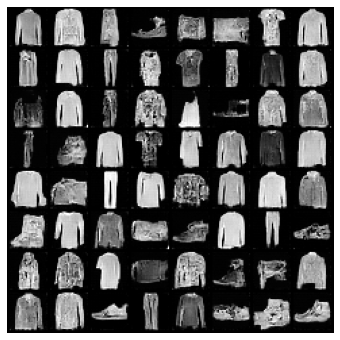

In [ ]:
#@title Sampling (double click to expand or collapse)

from torchvision.utils import make_grid

## Load the pre-trained checkpoint from disk.
device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}
ckpt = torch.load('ckpt.pth', map_location=device)
score_model.load_state_dict(ckpt)

noise_scale_func = functools.partial(noise_scale, sigma_min=sigma_min, sigma_max=sigma_max, grad=True)
sample_batch_size = 64 #@param {'type':'integer'}
sampler = pc_sampler #@param ['sde_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}

## Generate samples using the specified sampler.
samples = sampler(score_model, noise_scale_func, sample_batch_size, device=device)

## Sample visualization.
samples = samples.clamp(0.0, 1.0)
import matplotlib.pyplot as plt
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

# My own codes